In [265]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pyspark as spark
import sklearn as sk
import seaborn as sns
import os
import datetime
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.constraints import max_norm

In [266]:
csv_path = '/Users/hanyan/Desktop/DSO428Project/df.csv'
df = pd.read_csv(csv_path,sep=";")
df = df.set_index('Date')
df.index = pd.to_datetime(df.index)
df_null = pd.isnull(df)
df_null = df[df_null == True]
df.dropna(inplace=True)
df=df[['Close', 'Compound_Score', 'Count_Negatives',
       'Count_Positives', 'Count_Neutrals']]
df

,Close,Compound_Score,Count_Negatives,Count_Positives,Count_Neutrals
Date,,,,,
2017-08-01 00:00:00,2825.92,0.082893,139.0,347.0,397.0
2017-08-01 01:00:00,2853.38,0.053160,111.0,193.0,320.0
2017-08-01 02:00:00,2841.60,0.124251,89.0,273.0,264.0
2017-08-01 03:00:00,2862.93,-0.021037,250.0,236.0,314.0
2017-08-01 04:00:00,2874.99,0.055437,114.0,195.0,305.0
...,...,...,...,...,...
2019-01-21 19:00:00,3579.58,0.048459,282.0,342.0,277.0
2019-01-21 20:00:00,3580.66,0.059675,235.0,331.0,307.0
2019-01-21 21:00:00,3560.70,0.111140,176.0,350.0,268.0


In [267]:
df.isna().sum()

Close              0
Compound_Score     0
Count_Negatives    0
Count_Positives    0
Count_Neutrals     0
dtype: int64

In [268]:
close = df['Close'].resample('D',label='right').mean()

In [269]:
df = df.resample('D').sum()

In [270]:
df = df.drop(columns=['Close'])

In [271]:
df = pd.concat([close,df], axis=1)

In [272]:
df_null = pd.isnull(df)
df_null = df[df_null == True]
df.dropna(inplace=True)
df

,Close,Compound_Score,Count_Negatives,Count_Positives,Count_Neutrals
Date,,,,,
2017-08-02,2764.869167,1.188751,2732.0,4734.0,9063.0
2017-08-03,2711.504737,1.483832,3233.0,5351.0,9806.0
2017-08-04,2745.320417,1.322492,2703.0,4150.0,7959.0
2017-08-05,2827.973750,2.157058,2115.0,6258.0,8731.0
2017-08-06,3161.758750,1.556564,2190.0,3754.0,6161.0
...,...,...,...,...,...
2019-01-17,3642.362083,2.769114,3648.0,7202.0,7294.0
2019-01-18,3640.878750,2.635743,3557.0,6999.0,7631.0
2019-01-19,3655.850417,3.439009,2634.0,6474.0,5650.0


In [273]:
int(538*0.8)

430

In [274]:
df_train = df.iloc[0:430]
df_test = df.iloc[430:]
df_train

,Close,Compound_Score,Count_Negatives,Count_Positives,Count_Neutrals
Date,,,,,
2017-08-02,2764.869167,1.188751,2732.0,4734.0,9063.0
2017-08-03,2711.504737,1.483832,3233.0,5351.0,9806.0
2017-08-04,2745.320417,1.322492,2703.0,4150.0,7959.0
2017-08-05,2827.973750,2.157058,2115.0,6258.0,8731.0
2017-08-06,3161.758750,1.556564,2190.0,3754.0,6161.0
...,...,...,...,...,...
2018-10-01,6605.262000,0.655011,961.0,1754.0,1784.0
2018-10-02,6584.135000,2.845861,3859.0,7756.0,7127.0
2018-10-03,6567.970833,3.326658,3440.0,8352.0,7393.0


In [275]:
dataset = df.values
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

In [276]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train

array([[-0.99357445, -0.45584463, -0.83018046, -0.79078572, -0.62379735],
       [-1.        , -0.33798344, -0.79900436, -0.76346609, -0.59291815],
       [-0.99592829, -0.40242584, -0.83198507, -0.81664416, -0.66967978],
       ...,
       [-0.53564699,  0.39807679, -0.78612321, -0.63058735, -0.69320283],
       [-0.54634723,  0.38838929, -0.80018668, -0.62735504, -0.64416184],
       [-0.53463114,  0.20693456, -0.74735532, -0.62438841, -0.64673857]])

In [319]:
train_X, train_y = train[:, 1:10], train[:,:1] # Determining multivariates and label
test_X, test_y = test[:,1:10], test[:,:1] # Determining multivariates and label
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) #Determining train_X,train_y,test_X,test_y

# Shaping data
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1])) 
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(430, 4) (430, 1) (108, 4) (108, 1)
(430, 1, 4) (430, 1) (108, 1, 4) (108, 1)


In [321]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model = Sequential()

model.add(LSTM(250, return_sequences = True,input_shape=(train_X.shape[1], train_X.shape[2])))# Determining # of Neural Nodes
model.add(Dense(1))
model.add(Dropout(0.1))

model.compile(loss='mape', optimizer=opt)
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 250)            255000    
_________________________________________________________________
dense_20 (Dense)             (None, 1, 1)              251       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1)              0         
Total params: 255,251
Trainable params: 255,251
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
6/6 - 1s - loss: 165.2658 - val_loss: 107.8561
Epoch 2/2000
6/6 - 0s - loss: 133.2986 - val_loss: 85.4829
Epoch 3/2000
6/6 - 0s - loss: 124.3030 - val_loss: 78.3452
Epoch 4/2000
6/6 - 0s - loss: 119.0500 - val_loss: 87.8813
Epoch 5/2000
6/6 - 0s - loss: 98.0898 - val_loss: 95.3267
Epoch 6/2000
6/6 - 0s - loss: 98.6985 - val_loss: 87.3283
Epoch 7/2000
6/6 - 0s - loss: 100.7914 - val_loss: 82.2518
Epoch 8/2000
6/6 - 0s - loss: 98.9791 - val_loss: 83.2659
Epoch 9/2000
6/6 - 0s - loss: 102.6307 - val_loss: 88.7697
Epoch 10/2000
6/6 - 0s - loss: 93.7346 - val_loss: 90.5940
Epoch 11/2000
6/6 - 0s - loss: 97.0114 - val_loss: 88.6101
Epoch 12/2000
6/6 - 0s - loss: 93.2945 - val_loss: 84.5956
Epoch 13/2000
6/6 - 0s - loss: 93.0252 - val_loss: 80.7856
Epoch 14/2000
6/6 - 0s - loss: 91.9149 - val_loss: 80.1394
Epoch 15/2000
6/6 - 0s - loss: 93.4170 - val_loss: 76.3793
Epoch 16/2000
6/6 - 0s - loss: 92.4230 - val_loss: 76.0702
Epoch 17/2000
6/6 - 0s - loss: 94.3949 - val_loss: 81.0033

6/6 - 0s - loss: 79.2000 - val_loss: 47.9747
Epoch 140/2000
6/6 - 0s - loss: 82.4073 - val_loss: 57.2521
Epoch 141/2000
6/6 - 0s - loss: 79.1703 - val_loss: 47.4390
Epoch 142/2000
6/6 - 0s - loss: 79.5261 - val_loss: 49.9885
Epoch 143/2000
6/6 - 0s - loss: 75.9542 - val_loss: 56.2076
Epoch 144/2000
6/6 - 0s - loss: 75.0754 - val_loss: 56.9093
Epoch 145/2000
6/6 - 0s - loss: 75.7997 - val_loss: 53.0458
Epoch 146/2000
6/6 - 0s - loss: 76.0565 - val_loss: 51.7124
Epoch 147/2000
6/6 - 0s - loss: 78.1919 - val_loss: 56.1617
Epoch 148/2000
6/6 - 0s - loss: 75.5840 - val_loss: 54.2448
Epoch 149/2000
6/6 - 0s - loss: 75.9078 - val_loss: 49.6215
Epoch 150/2000
6/6 - 0s - loss: 78.1608 - val_loss: 52.3959
Epoch 151/2000
6/6 - 0s - loss: 77.1074 - val_loss: 58.7552
Epoch 152/2000
6/6 - 0s - loss: 77.0443 - val_loss: 45.1782
Epoch 153/2000
6/6 - 0s - loss: 86.0730 - val_loss: 50.9596
Epoch 154/2000
6/6 - 0s - loss: 76.4703 - val_loss: 63.2199
Epoch 155/2000
6/6 - 0s - loss: 77.9695 - val_loss: 45.

Epoch 276/2000
6/6 - 0s - loss: 83.0896 - val_loss: 44.8672
Epoch 277/2000
6/6 - 0s - loss: 71.9456 - val_loss: 48.4687
Epoch 278/2000
6/6 - 0s - loss: 72.2459 - val_loss: 54.0847
Epoch 279/2000
6/6 - 0s - loss: 74.4806 - val_loss: 44.5795
Epoch 280/2000
6/6 - 0s - loss: 72.4376 - val_loss: 46.8111
Epoch 281/2000
6/6 - 0s - loss: 69.0665 - val_loss: 47.7238
Epoch 282/2000
6/6 - 0s - loss: 68.5692 - val_loss: 41.8976
Epoch 283/2000
6/6 - 0s - loss: 73.5684 - val_loss: 48.0808
Epoch 284/2000
6/6 - 0s - loss: 67.7607 - val_loss: 44.8907
Epoch 285/2000
6/6 - 0s - loss: 74.2087 - val_loss: 47.1892
Epoch 286/2000
6/6 - 0s - loss: 67.9697 - val_loss: 44.7472
Epoch 287/2000
6/6 - 0s - loss: 70.3367 - val_loss: 50.5458
Epoch 288/2000
6/6 - 0s - loss: 73.9811 - val_loss: 45.2518
Epoch 289/2000
6/6 - 0s - loss: 66.7863 - val_loss: 46.1536
Epoch 290/2000
6/6 - 0s - loss: 67.8330 - val_loss: 43.3759
Epoch 291/2000
6/6 - 0s - loss: 68.5053 - val_loss: 49.4337
Epoch 292/2000
6/6 - 0s - loss: 70.4599 

Epoch 413/2000
6/6 - 0s - loss: 66.8435 - val_loss: 40.2289
Epoch 414/2000
6/6 - 0s - loss: 63.7111 - val_loss: 44.0421
Epoch 415/2000
6/6 - 0s - loss: 72.1681 - val_loss: 41.2542
Epoch 416/2000
6/6 - 0s - loss: 64.9458 - val_loss: 46.0678
Epoch 417/2000
6/6 - 0s - loss: 71.4486 - val_loss: 41.8294
Epoch 418/2000
6/6 - 0s - loss: 67.2385 - val_loss: 41.3336
Epoch 419/2000
6/6 - 0s - loss: 68.5201 - val_loss: 40.5773
Epoch 420/2000
6/6 - 0s - loss: 64.1349 - val_loss: 46.2999
Epoch 421/2000
6/6 - 0s - loss: 67.3312 - val_loss: 45.9458
Epoch 422/2000
6/6 - 0s - loss: 66.6658 - val_loss: 38.7597
Epoch 423/2000
6/6 - 0s - loss: 70.6007 - val_loss: 43.5980
Epoch 424/2000
6/6 - 0s - loss: 67.3248 - val_loss: 46.0149
Epoch 425/2000
6/6 - 0s - loss: 64.6174 - val_loss: 41.5649
Epoch 426/2000
6/6 - 0s - loss: 67.2867 - val_loss: 45.8762
Epoch 427/2000
6/6 - 0s - loss: 69.8334 - val_loss: 43.5372
Epoch 428/2000
6/6 - 0s - loss: 67.6962 - val_loss: 37.4904
Epoch 429/2000
6/6 - 0s - loss: 75.7395 

Epoch 550/2000
6/6 - 0s - loss: 75.3452 - val_loss: 45.0813
Epoch 551/2000
6/6 - 0s - loss: 65.3801 - val_loss: 36.2973
Epoch 552/2000
6/6 - 0s - loss: 69.6719 - val_loss: 41.3437
Epoch 553/2000
6/6 - 0s - loss: 68.0840 - val_loss: 44.4037
Epoch 554/2000
6/6 - 0s - loss: 66.0632 - val_loss: 39.9034
Epoch 555/2000
6/6 - 0s - loss: 68.1271 - val_loss: 43.7033
Epoch 556/2000
6/6 - 0s - loss: 65.3219 - val_loss: 52.3775
Epoch 557/2000
6/6 - 0s - loss: 69.9045 - val_loss: 44.5431
Epoch 558/2000
6/6 - 0s - loss: 65.2930 - val_loss: 42.2973
Epoch 559/2000
6/6 - 0s - loss: 63.8442 - val_loss: 43.8775
Epoch 560/2000
6/6 - 0s - loss: 65.3028 - val_loss: 39.6372
Epoch 561/2000
6/6 - 0s - loss: 66.3008 - val_loss: 43.1332
Epoch 562/2000
6/6 - 0s - loss: 68.1443 - val_loss: 43.8275
Epoch 563/2000
6/6 - 0s - loss: 66.1073 - val_loss: 39.0220
Epoch 564/2000
6/6 - 0s - loss: 69.1011 - val_loss: 44.6137
Epoch 565/2000
6/6 - 0s - loss: 68.3805 - val_loss: 47.5037
Epoch 566/2000
6/6 - 0s - loss: 64.2267 

Epoch 687/2000
6/6 - 0s - loss: 63.9322 - val_loss: 41.7437
Epoch 688/2000
6/6 - 0s - loss: 61.7116 - val_loss: 42.4660
Epoch 689/2000
6/6 - 0s - loss: 64.1987 - val_loss: 38.6618
Epoch 690/2000
6/6 - 0s - loss: 70.3288 - val_loss: 43.7395
Epoch 691/2000
6/6 - 0s - loss: 63.2357 - val_loss: 43.7759
Epoch 692/2000
6/6 - 0s - loss: 63.2318 - val_loss: 41.1954
Epoch 693/2000
6/6 - 0s - loss: 61.6438 - val_loss: 37.4614
Epoch 694/2000
6/6 - 0s - loss: 70.1468 - val_loss: 44.8396
Epoch 695/2000
6/6 - 0s - loss: 66.1170 - val_loss: 44.7204
Epoch 696/2000
6/6 - 0s - loss: 67.3549 - val_loss: 44.4238
Epoch 697/2000
6/6 - 0s - loss: 65.6671 - val_loss: 40.6821
Epoch 698/2000
6/6 - 0s - loss: 67.7966 - val_loss: 45.6138
Epoch 699/2000
6/6 - 0s - loss: 66.0261 - val_loss: 46.4507
Epoch 700/2000
6/6 - 0s - loss: 62.8650 - val_loss: 39.9843
Epoch 701/2000
6/6 - 0s - loss: 66.7644 - val_loss: 42.0625
Epoch 702/2000
6/6 - 0s - loss: 61.0516 - val_loss: 41.5162
Epoch 703/2000
6/6 - 0s - loss: 67.0329 

Epoch 824/2000
6/6 - 0s - loss: 65.5364 - val_loss: 46.3959
Epoch 825/2000
6/6 - 0s - loss: 63.7438 - val_loss: 45.6387
Epoch 826/2000
6/6 - 0s - loss: 62.3326 - val_loss: 39.4354
Epoch 827/2000
6/6 - 0s - loss: 64.8126 - val_loss: 42.2994
Epoch 828/2000
6/6 - 0s - loss: 65.1674 - val_loss: 40.8865
Epoch 829/2000
6/6 - 0s - loss: 61.2034 - val_loss: 41.6267
Epoch 830/2000
6/6 - 0s - loss: 62.6158 - val_loss: 41.3853
Epoch 831/2000
6/6 - 0s - loss: 63.8618 - val_loss: 40.4150
Epoch 832/2000
6/6 - 0s - loss: 60.7364 - val_loss: 40.5804
Epoch 833/2000
6/6 - 0s - loss: 62.5713 - val_loss: 39.9973
Epoch 834/2000
6/6 - 0s - loss: 61.1091 - val_loss: 40.1493
Epoch 835/2000
6/6 - 0s - loss: 60.1679 - val_loss: 37.5461
Epoch 836/2000
6/6 - 0s - loss: 65.0543 - val_loss: 42.6772
Epoch 837/2000
6/6 - 0s - loss: 63.9116 - val_loss: 42.0933
Epoch 838/2000
6/6 - 0s - loss: 61.8335 - val_loss: 43.8187
Epoch 839/2000
6/6 - 0s - loss: 61.7426 - val_loss: 42.5557
Epoch 840/2000
6/6 - 0s - loss: 61.7143 

Epoch 961/2000
6/6 - 0s - loss: 63.0681 - val_loss: 38.9991
Epoch 962/2000
6/6 - 0s - loss: 62.0676 - val_loss: 40.7064
Epoch 963/2000
6/6 - 0s - loss: 60.1514 - val_loss: 42.8175
Epoch 964/2000
6/6 - 0s - loss: 61.6402 - val_loss: 38.1982
Epoch 965/2000
6/6 - 0s - loss: 70.2506 - val_loss: 43.1891
Epoch 966/2000
6/6 - 0s - loss: 62.8212 - val_loss: 48.5562
Epoch 967/2000
6/6 - 0s - loss: 69.7250 - val_loss: 41.2945
Epoch 968/2000
6/6 - 0s - loss: 61.6095 - val_loss: 37.3768
Epoch 969/2000
6/6 - 0s - loss: 61.1744 - val_loss: 46.0322
Epoch 970/2000
6/6 - 0s - loss: 72.6599 - val_loss: 44.3901
Epoch 971/2000
6/6 - 0s - loss: 61.6805 - val_loss: 37.2305
Epoch 972/2000
6/6 - 0s - loss: 66.6388 - val_loss: 42.9025
Epoch 973/2000
6/6 - 0s - loss: 65.4615 - val_loss: 43.1583
Epoch 974/2000
6/6 - 0s - loss: 61.6432 - val_loss: 37.0063
Epoch 975/2000
6/6 - 0s - loss: 68.9794 - val_loss: 42.0566
Epoch 976/2000
6/6 - 0s - loss: 61.1413 - val_loss: 44.8186
Epoch 977/2000
6/6 - 0s - loss: 61.1756 

Epoch 1096/2000
6/6 - 0s - loss: 63.4693 - val_loss: 42.3162
Epoch 1097/2000
6/6 - 0s - loss: 62.4840 - val_loss: 45.9475
Epoch 1098/2000
6/6 - 0s - loss: 63.8713 - val_loss: 39.6924
Epoch 1099/2000
6/6 - 0s - loss: 61.4590 - val_loss: 41.6997
Epoch 1100/2000
6/6 - 0s - loss: 60.7101 - val_loss: 41.3451
Epoch 1101/2000
6/6 - 0s - loss: 62.8219 - val_loss: 37.4187
Epoch 1102/2000
6/6 - 0s - loss: 66.7071 - val_loss: 44.5906
Epoch 1103/2000
6/6 - 0s - loss: 63.2900 - val_loss: 45.1449
Epoch 1104/2000
6/6 - 0s - loss: 61.2637 - val_loss: 38.7342
Epoch 1105/2000
6/6 - 0s - loss: 62.3968 - val_loss: 43.8905
Epoch 1106/2000
6/6 - 0s - loss: 66.8538 - val_loss: 44.6159
Epoch 1107/2000
6/6 - 0s - loss: 64.4257 - val_loss: 36.5902
Epoch 1108/2000
6/6 - 0s - loss: 67.0842 - val_loss: 39.1879
Epoch 1109/2000
6/6 - 0s - loss: 60.9794 - val_loss: 44.1271
Epoch 1110/2000
6/6 - 0s - loss: 63.0204 - val_loss: 41.6326
Epoch 1111/2000
6/6 - 0s - loss: 61.5925 - val_loss: 37.8819
Epoch 1112/2000
6/6 - 0s

Epoch 1231/2000
6/6 - 0s - loss: 62.9494 - val_loss: 44.3054
Epoch 1232/2000
6/6 - 0s - loss: 59.2957 - val_loss: 40.0087
Epoch 1233/2000
6/6 - 0s - loss: 60.3521 - val_loss: 41.9032
Epoch 1234/2000
6/6 - 0s - loss: 63.2218 - val_loss: 39.7712
Epoch 1235/2000
6/6 - 0s - loss: 61.3974 - val_loss: 40.8775
Epoch 1236/2000
6/6 - 0s - loss: 59.7521 - val_loss: 39.3007
Epoch 1237/2000
6/6 - 0s - loss: 60.8672 - val_loss: 43.5605
Epoch 1238/2000
6/6 - 0s - loss: 60.3791 - val_loss: 40.4948
Epoch 1239/2000
6/6 - 0s - loss: 64.3068 - val_loss: 40.6815
Epoch 1240/2000
6/6 - 0s - loss: 61.0833 - val_loss: 41.4837
Epoch 1241/2000
6/6 - 0s - loss: 59.9721 - val_loss: 38.9191
Epoch 1242/2000
6/6 - 0s - loss: 64.3588 - val_loss: 43.8127
Epoch 1243/2000
6/6 - 0s - loss: 62.8362 - val_loss: 43.1042
Epoch 1244/2000
6/6 - 0s - loss: 60.0963 - val_loss: 38.6814
Epoch 1245/2000
6/6 - 0s - loss: 64.8760 - val_loss: 44.9590
Epoch 1246/2000
6/6 - 0s - loss: 64.1886 - val_loss: 44.7607
Epoch 1247/2000
6/6 - 0s

Epoch 1366/2000
6/6 - 0s - loss: 58.6107 - val_loss: 38.1372
Epoch 1367/2000
6/6 - 0s - loss: 62.3068 - val_loss: 42.9988
Epoch 1368/2000
6/6 - 0s - loss: 62.9387 - val_loss: 43.1740
Epoch 1369/2000
6/6 - 0s - loss: 61.6514 - val_loss: 40.2698
Epoch 1370/2000
6/6 - 0s - loss: 57.7883 - val_loss: 41.3391
Epoch 1371/2000
6/6 - 0s - loss: 60.6903 - val_loss: 39.4449
Epoch 1372/2000
6/6 - 0s - loss: 61.1145 - val_loss: 45.3162
Epoch 1373/2000
6/6 - 0s - loss: 61.9150 - val_loss: 41.8165
Epoch 1374/2000
6/6 - 0s - loss: 61.7743 - val_loss: 41.0494
Epoch 1375/2000
6/6 - 0s - loss: 62.2396 - val_loss: 39.8609
Epoch 1376/2000
6/6 - 0s - loss: 59.7376 - val_loss: 39.9012
Epoch 1377/2000
6/6 - 0s - loss: 62.2100 - val_loss: 45.0016
Epoch 1378/2000
6/6 - 0s - loss: 64.7881 - val_loss: 40.8334
Epoch 1379/2000
6/6 - 0s - loss: 62.2579 - val_loss: 40.7195
Epoch 1380/2000
6/6 - 0s - loss: 61.1410 - val_loss: 38.5796
Epoch 1381/2000
6/6 - 0s - loss: 62.4582 - val_loss: 44.0384
Epoch 1382/2000
6/6 - 0s

Epoch 1501/2000
6/6 - 0s - loss: 58.9904 - val_loss: 40.9791
Epoch 1502/2000
6/6 - 0s - loss: 59.3625 - val_loss: 41.2800
Epoch 1503/2000
6/6 - 0s - loss: 60.9347 - val_loss: 39.8292
Epoch 1504/2000
6/6 - 0s - loss: 59.5794 - val_loss: 43.3748
Epoch 1505/2000
6/6 - 0s - loss: 62.7211 - val_loss: 39.4827
Epoch 1506/2000
6/6 - 0s - loss: 60.7747 - val_loss: 41.0143
Epoch 1507/2000
6/6 - 0s - loss: 59.2542 - val_loss: 39.0426
Epoch 1508/2000
6/6 - 0s - loss: 59.0759 - val_loss: 41.1820
Epoch 1509/2000
6/6 - 0s - loss: 61.4983 - val_loss: 42.5666
Epoch 1510/2000
6/6 - 0s - loss: 59.3245 - val_loss: 40.8684
Epoch 1511/2000
6/6 - 0s - loss: 61.9791 - val_loss: 39.0328
Epoch 1512/2000
6/6 - 0s - loss: 60.2949 - val_loss: 44.3258
Epoch 1513/2000
6/6 - 0s - loss: 65.9423 - val_loss: 41.4826
Epoch 1514/2000
6/6 - 0s - loss: 59.4994 - val_loss: 37.0764
Epoch 1515/2000
6/6 - 0s - loss: 62.8412 - val_loss: 45.0924
Epoch 1516/2000
6/6 - 0s - loss: 67.0948 - val_loss: 40.7690
Epoch 1517/2000
6/6 - 0s

Epoch 1636/2000
6/6 - 0s - loss: 61.8782 - val_loss: 39.2634
Epoch 1637/2000
6/6 - 0s - loss: 59.2121 - val_loss: 37.6567
Epoch 1638/2000
6/6 - 0s - loss: 61.2695 - val_loss: 43.3563
Epoch 1639/2000
6/6 - 0s - loss: 60.8914 - val_loss: 41.4903
Epoch 1640/2000
6/6 - 0s - loss: 58.2602 - val_loss: 40.6357
Epoch 1641/2000
6/6 - 0s - loss: 59.9314 - val_loss: 40.5100
Epoch 1642/2000
6/6 - 0s - loss: 58.4558 - val_loss: 37.5461
Epoch 1643/2000
6/6 - 0s - loss: 62.7376 - val_loss: 44.2272
Epoch 1644/2000
6/6 - 0s - loss: 64.5012 - val_loss: 41.7009
Epoch 1645/2000
6/6 - 0s - loss: 57.3578 - val_loss: 38.1508
Epoch 1646/2000
6/6 - 0s - loss: 59.2839 - val_loss: 37.7459
Epoch 1647/2000
6/6 - 0s - loss: 58.8018 - val_loss: 43.0506
Epoch 1648/2000
6/6 - 0s - loss: 60.5718 - val_loss: 40.1566
Epoch 1649/2000
6/6 - 0s - loss: 64.7843 - val_loss: 42.9550
Epoch 1650/2000
6/6 - 0s - loss: 59.4576 - val_loss: 43.0915
Epoch 1651/2000
6/6 - 0s - loss: 60.3230 - val_loss: 39.6903
Epoch 1652/2000
6/6 - 0s

Epoch 1771/2000
6/6 - 0s - loss: 63.1419 - val_loss: 41.4670
Epoch 1772/2000
6/6 - 0s - loss: 57.8036 - val_loss: 38.6671
Epoch 1773/2000
6/6 - 0s - loss: 63.9135 - val_loss: 45.4750
Epoch 1774/2000
6/6 - 0s - loss: 61.7657 - val_loss: 42.3898
Epoch 1775/2000
6/6 - 0s - loss: 60.0490 - val_loss: 41.6792
Epoch 1776/2000
6/6 - 0s - loss: 59.8220 - val_loss: 39.9075
Epoch 1777/2000
6/6 - 0s - loss: 58.4629 - val_loss: 42.9422
Epoch 1778/2000
6/6 - 0s - loss: 59.5523 - val_loss: 40.1776
Epoch 1779/2000
6/6 - 0s - loss: 63.5001 - val_loss: 44.1145
Epoch 1780/2000
6/6 - 0s - loss: 58.8161 - val_loss: 41.7094
Epoch 1781/2000
6/6 - 0s - loss: 59.5363 - val_loss: 38.3010
Epoch 1782/2000
6/6 - 0s - loss: 58.6111 - val_loss: 41.9385
Epoch 1783/2000
6/6 - 0s - loss: 59.7423 - val_loss: 40.4739
Epoch 1784/2000
6/6 - 0s - loss: 60.7199 - val_loss: 43.6988
Epoch 1785/2000
6/6 - 0s - loss: 59.8121 - val_loss: 39.5644
Epoch 1786/2000
6/6 - 0s - loss: 62.5411 - val_loss: 43.1957
Epoch 1787/2000
6/6 - 0s

Epoch 1906/2000
6/6 - 0s - loss: 61.6930 - val_loss: 38.0213
Epoch 1907/2000
6/6 - 0s - loss: 62.2189 - val_loss: 42.4259
Epoch 1908/2000
6/6 - 0s - loss: 60.4065 - val_loss: 41.4202
Epoch 1909/2000
6/6 - 0s - loss: 60.8729 - val_loss: 45.3487
Epoch 1910/2000
6/6 - 0s - loss: 60.0904 - val_loss: 41.9226
Epoch 1911/2000
6/6 - 0s - loss: 58.7172 - val_loss: 37.2444
Epoch 1912/2000
6/6 - 0s - loss: 59.2995 - val_loss: 43.1646
Epoch 1913/2000
6/6 - 0s - loss: 59.7797 - val_loss: 43.1598
Epoch 1914/2000
6/6 - 0s - loss: 60.3575 - val_loss: 45.8520
Epoch 1915/2000
6/6 - 0s - loss: 60.4687 - val_loss: 41.5510
Epoch 1916/2000
6/6 - 0s - loss: 62.1921 - val_loss: 38.0928
Epoch 1917/2000
6/6 - 0s - loss: 58.3571 - val_loss: 41.9766
Epoch 1918/2000
6/6 - 0s - loss: 60.1176 - val_loss: 40.5896
Epoch 1919/2000
6/6 - 0s - loss: 62.4587 - val_loss: 43.4018
Epoch 1920/2000
6/6 - 0s - loss: 58.7256 - val_loss: 39.7102
Epoch 1921/2000
6/6 - 0s - loss: 63.9835 - val_loss: 41.8218
Epoch 1922/2000
6/6 - 0s

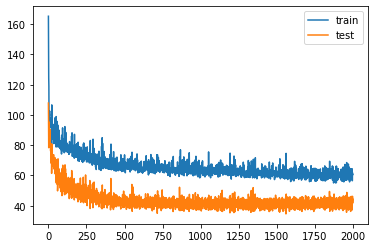

In [322]:
MTS_RNN = model.fit(train_X, train_y, epochs=2000, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle= False)

plt.plot(MTS_RNN.history['loss'], label='train')
plt.plot(MTS_RNN.history['val_loss'], label='test')
plt.legend()
plt.show()

In [323]:
model

In [324]:
#Prediction by Multivariate Time Series through NN

train_predict = model.predict(train_X)    
test_predict = model.predict(test_X) 

In [325]:
#Converting from three dimension to two dimension

train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [326]:
#Reshaping

train_predict = train_predict.reshape((train_X.shape[0],1))
test_predict = test_predict.reshape((test_X.shape[0],1))

In [327]:
#Concatenate

inv_train_predict = concatenate((train_predict, train_X), axis=1)
inv_test_predict = concatenate((test_predict, test_X), axis=1)

In [328]:
#Transforming to original scale

inv_train_predict = scaler.inverse_transform(inv_train_predict)
inv_test_predict = scaler.inverse_transform(inv_test_predict) 

In [329]:
#Predicted values on training data
inv_train_predict = inv_train_predict[:,0]
inv_train_predict
#Predicted values on testing data
inv_test_predict = inv_test_predict[:,0]
inv_test_predict

array([ 7152.37438947,  6681.62226695,  7764.77207287,  7433.74434474,
        6139.0909884 ,  8351.98371406,  7104.96598032,  6772.85960705,
        7139.78656605,  8732.09449865,  8068.35399969,  7778.77861908,
        7572.81135467,  6695.92334912,  6402.24624587,  6648.3921754 ,
        4447.29177855,  8230.1631459 ,  7236.83591743,  7203.75928159,
        7206.58534175,  6458.01551614,  6306.61413223,  7986.0255061 ,
        7583.32802102,  8052.57380248,  7780.82453021,  8054.64198944,
        6417.03096104,  4248.83740871,  7815.30998848, 11098.16566247,
        7513.30519034, 11068.91978856, 11040.95223784,  6736.85741234,
        6576.94270164, 10722.45354969,  6751.40550871,  9009.70417025,
       11081.62307502,  7728.17536104,  6813.38825019,  7156.74193699,
        8909.36604024, 10889.12575685,  8666.6837546 ,  8143.26761236,
        7097.23082248,  6653.54878228,  9966.827484  , 10033.44706303,
        8803.86672442,  9167.55044649,  8823.39668617,  8668.37919269,
      

In [330]:
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = concatenate((train_y, train_X), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:,0]

In [331]:
test_y = test_y.reshape((len(test_y), 1))
inv_test_y = concatenate((test_y, test_X), axis=1)
inv_test_y = scaler.inverse_transform(inv_test_y)
inv_test_y = inv_test_y[:,0]

In [332]:
rmse_train = sqrt(mean_squared_error(inv_train_y, inv_train_predict))
print('Test RMSE: %.3f' % rmse_train)

Test RMSE: 2507.609


In [333]:
rmse_test = sqrt(mean_squared_error(inv_test_y, inv_test_predict))
print('Test RMSE: %.3f' % rmse_test)

Test RMSE: 3296.579


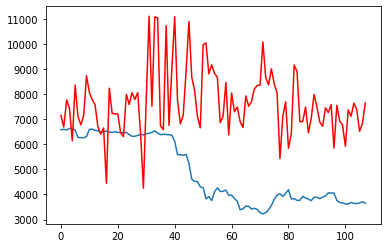

In [334]:
inv_test_y = inv_test_y.reshape(-1,1)
inv_test_y.shape

t = np.arange(0,108,1)

plt.plot(t,inv_test_y,label="actual")
plt.plot(t,inv_test_predict,'r',label="predicted")
plt.show()

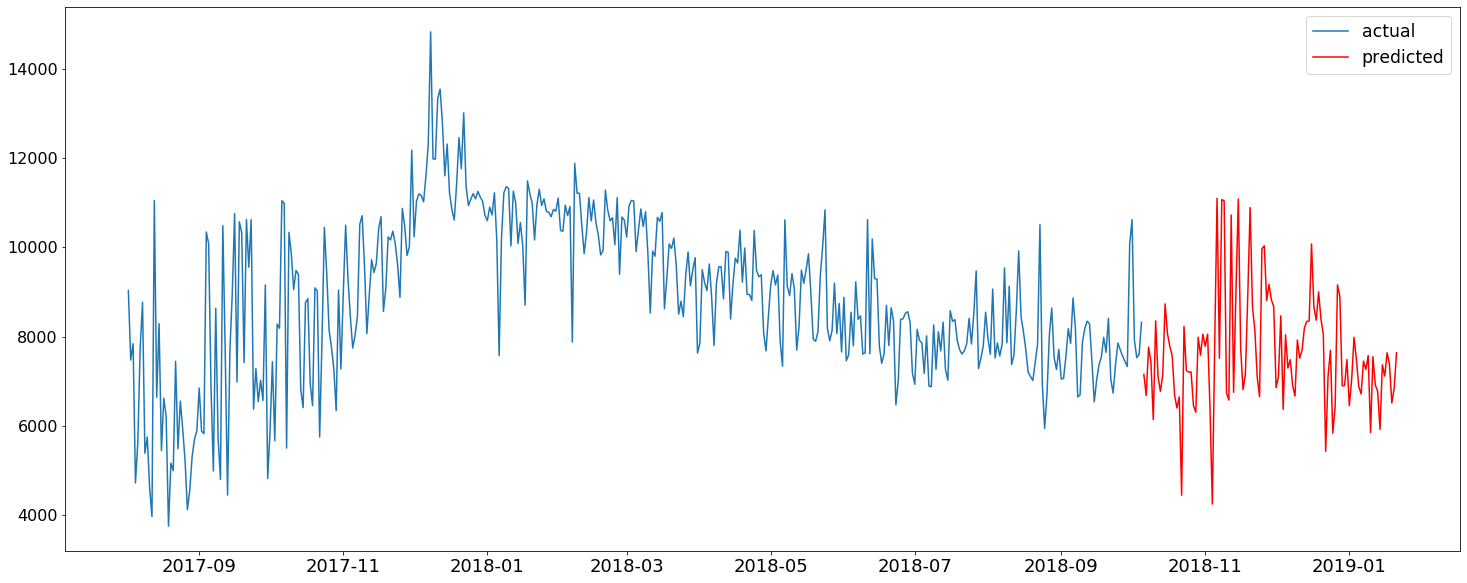

In [335]:
plt.figure(figsize=(25, 10))
plt.plot(df_train.index, inv_train_predict,label="actual")
plt.plot(df_test.index, inv_test_predict, color='r',label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

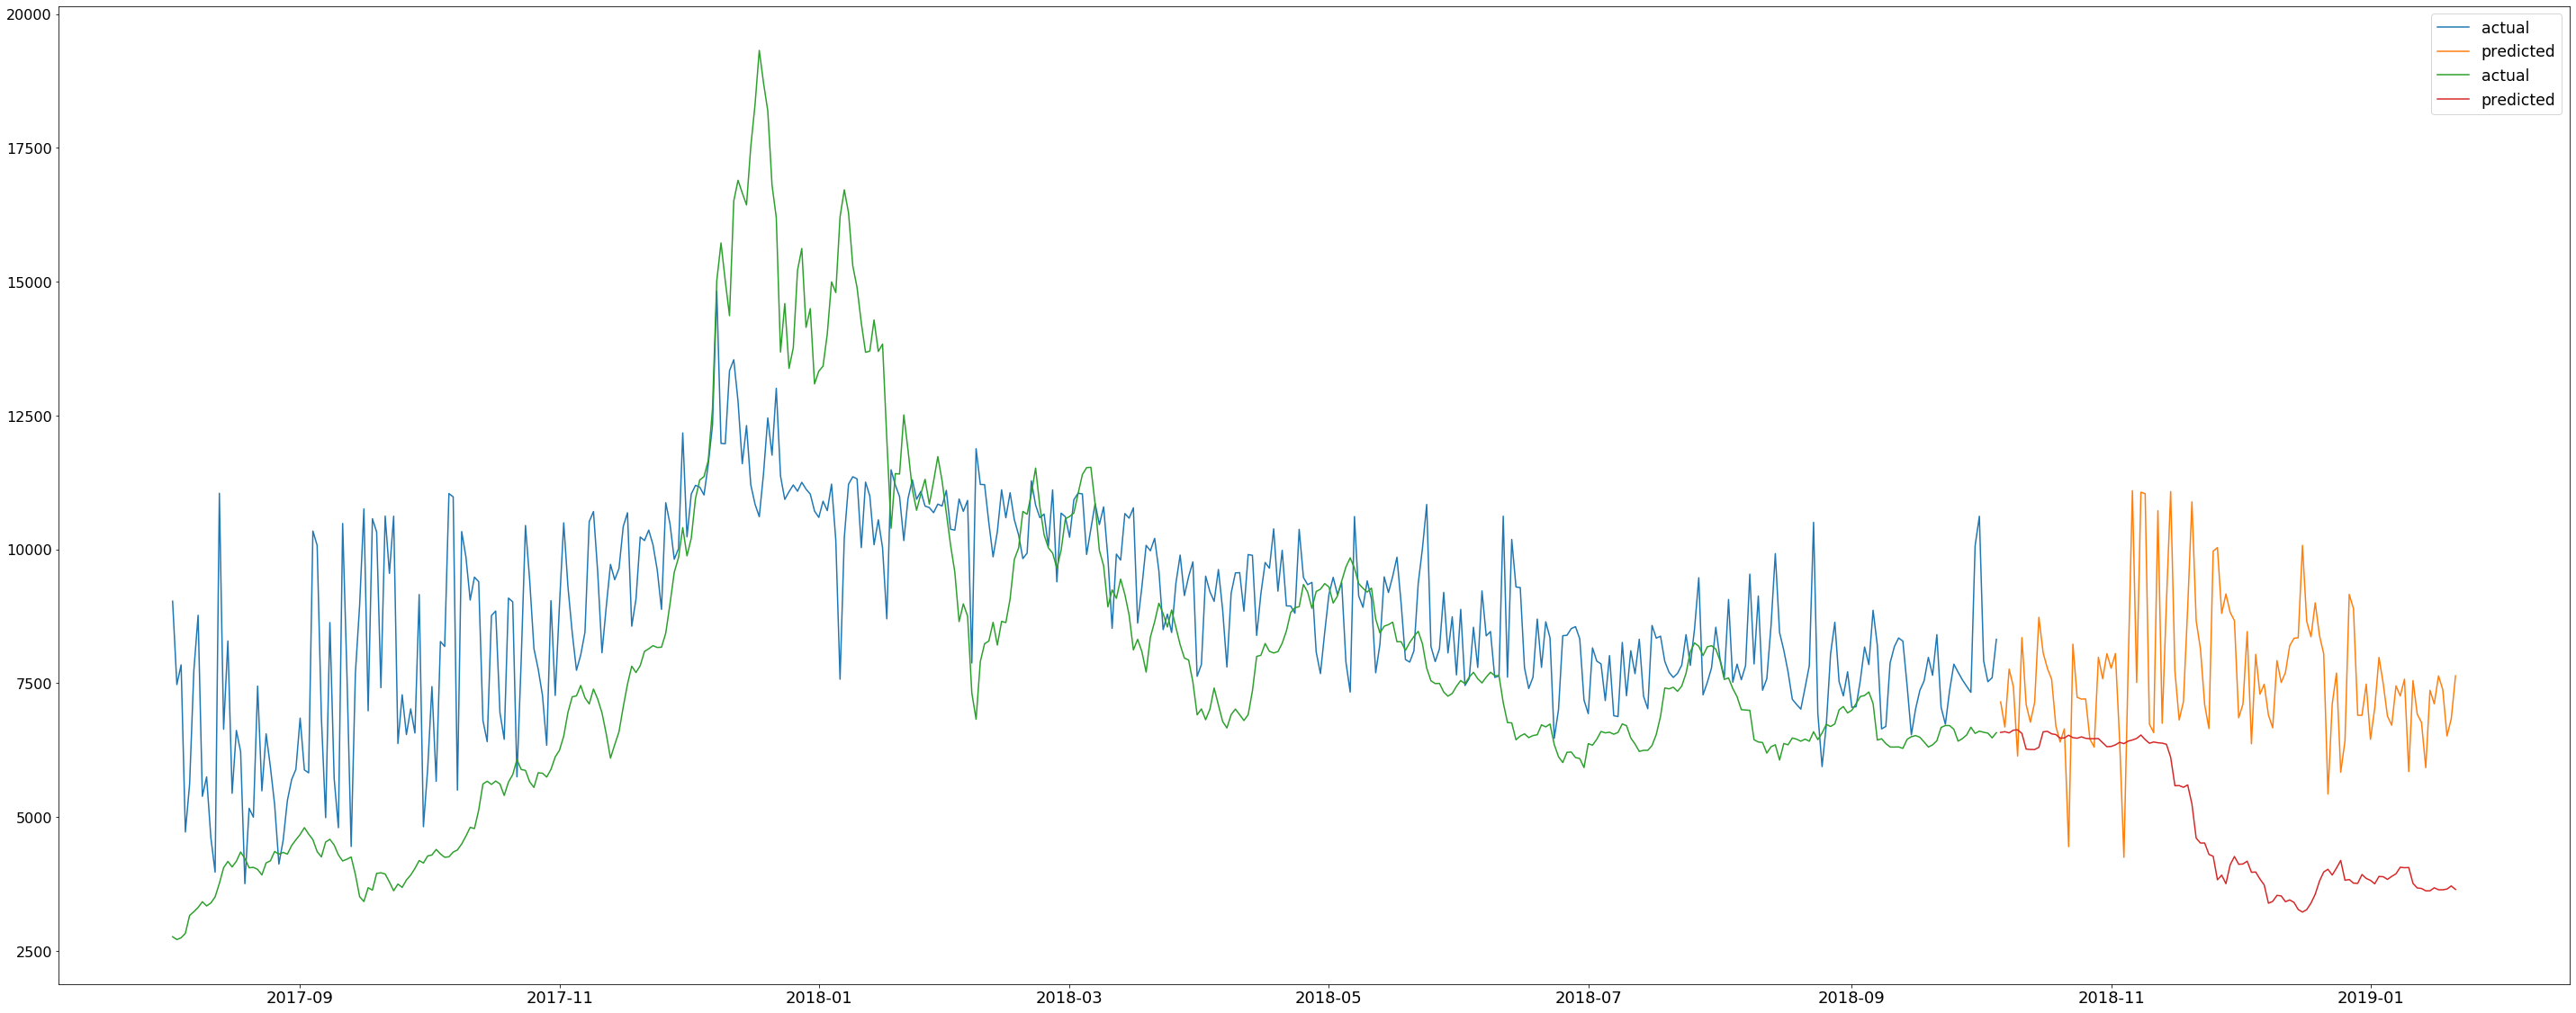

In [336]:
plt.figure(figsize=(50, 20))
plt.plot(df_train.index, inv_train_predict,label="actual")
plt.plot(df_test.index, inv_test_predict,label="predicted")
plt.plot(df_train.index, inv_train_y,label="actual")
plt.plot(df_test.index, inv_test_y,label="predicted")
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [337]:
MAPE = tf.keras.losses.MAPE(
    inv_test_y, inv_test_predict
)
def average(a,n):
    sum = 0
    for i in range(n):
        sum += a[i]
    return sum/n;
n = len(MAPE)
print(average(MAPE,n))

tf.Tensor(67.89719005742633, shape=(), dtype=float64)


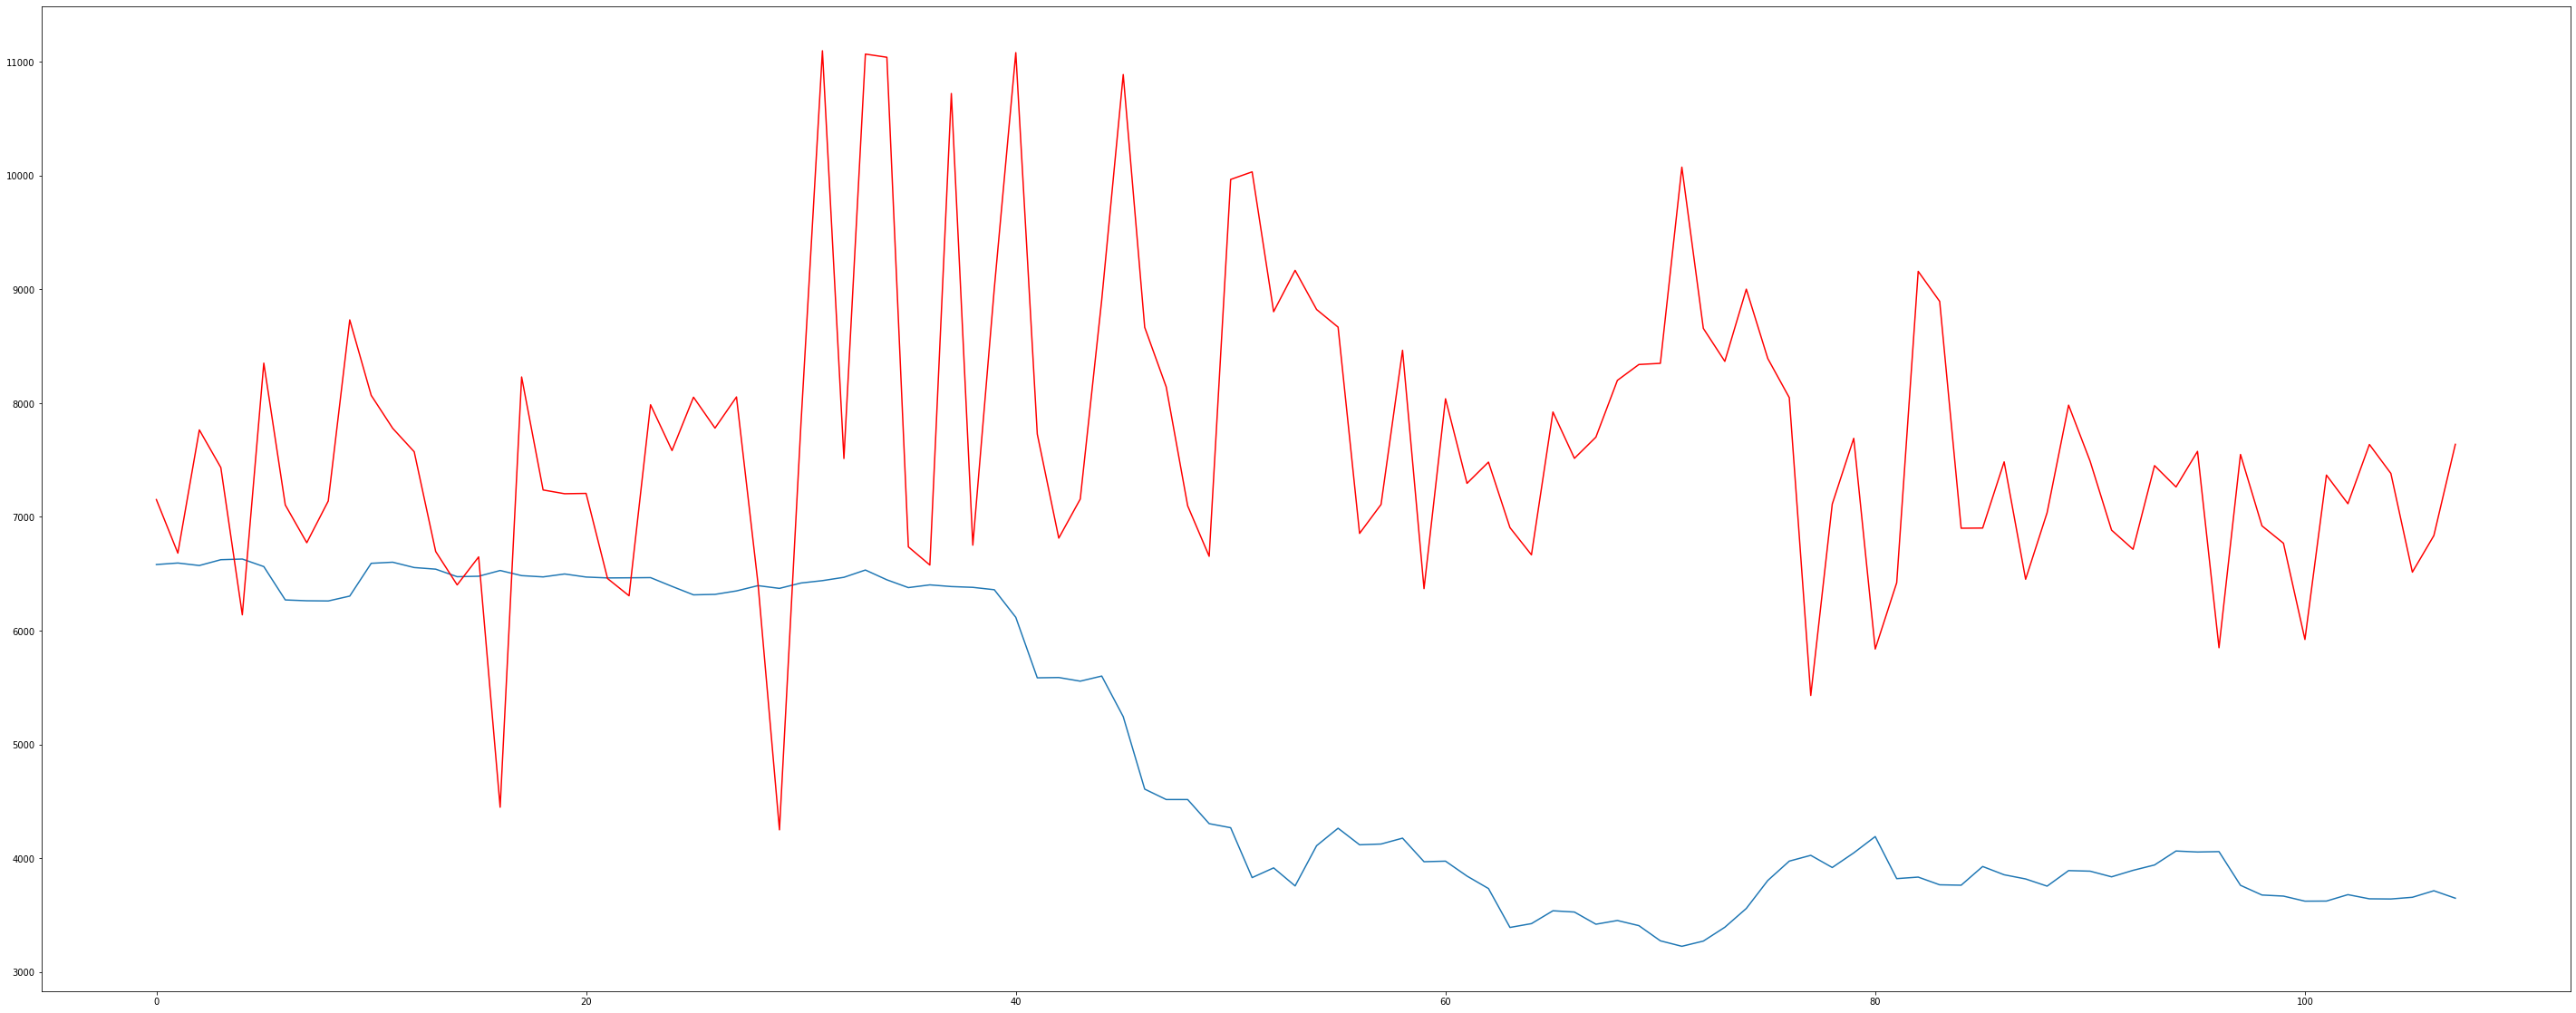

In [338]:
inv_test_y = inv_test_y.reshape(-1,1)
inv_test_y.shape

t = np.arange(0,108,1)
plt.figure(figsize=(50, 20))
plt.plot(t,inv_test_y,label="actual")
plt.plot(t,inv_test_predict,'r',label="predicted")
plt.show()